# EPI Scenario 1
## Create a SEIcImRD base model
We start by creating a base model that can be extended further to the different use cases

### TODOs
- Take interactions from interaction matrix
- 

In [1]:
# General imports
import sympy
from mira.metamodel import *
from mira.examples.concepts import susceptible, exposed, infected, recovered, dead
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel
from mira.modeling.viz import GraphicalModel
from mira.metamodel.io import model_to_json_file, model_from_json_file
from pathlib import Path
scenario1_supp_dir = Path('Scenario_1_Supplemental')

# Load the supporting data
import pandas as pd
data = {}
for file in scenario1_supp_dir.glob('*.csv'):
        country = file.name.split('_')[0]
        if country not in data:
            data[country] = {}
        ftype = file.name.lstrip(country + '_').rstrip('.csv')
        data[country][ftype] = pd.read_csv(file, index_col=0)

data['France']['population']

,country,age_group,n,matrix,iso3c
1,France,0-4,3619987,9,FRA
2,France,9-May,3907487,9,FRA
3,France,14-Oct,3995688,9,FRA
4,France,15-19,3887789,9,FRA
5,France,20-24,3697019,9,FRA
6,France,25-29,3674010,9,FRA
7,France,30-34,3941533,9,FRA
8,France,35-39,4069517,9,FRA
9,France,40-44,3943397,9,FRA
10,France,45-49,4382270,9,FRA


In [2]:
# Fix Excelized values
data['France']['population'].at[2, 'age_group'] = '5-9'
data['France']['population'].at[3, 'age_group'] = '10-14'
data['France']['population'].head()

,country,age_group,n,matrix,iso3c
1,France,0-4,3619987,9,FRA
2,France,5-9,3907487,9,FRA
3,France,10-14,3995688,9,FRA
4,France,15-19,3887789,9,FRA
5,France,20-24,3697019,9,FRA


We have the following compartments: S, E, ICase, IMild, R, and D. All patients in IMild transition to R, whereas all patients in ICase transition to the hospital (IHospital, not currently included in this output). From there, some patients recover and others transition to Deceased/Death.

In [3]:
# Build base model

person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

_infected = Concept(name='I', units=person_units(), identifiers={'ido': '0000511'})

c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '00000154'}),
    'I_mild': _infected.with_context(status="mild"),
    'I_case': _infected.with_context(status="case "),
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    'D': Concept(name='D', units=person_units(), identifiers={'ncit': 'C28554'}),
}
c['I_case'].name = 'I_case'
c['I_mild'].name = 'I_mild'


# TODO: set proper parameter names - beta, gamma, etc
parameters = {
    'r_SE_mild': Parameter(name='r_SE_mild', units=per_day_units()),  # Infection rate from I_mild
    'r_SE_case': Parameter(name='r_SE_case', units=per_day_units()),  # Infection rate from I_case
    'r_EI_mild': Parameter(name='r_EI_mild', units=per_day_units()),  # Rate of progressing E -> I_mild
    'r_EI_case': Parameter(name='r_EI_case', units=per_day_units()),  # Rate of progressing E -> I_case
    'r_I_mildR': Parameter(name='r_I_mildR', units=per_day_units()),  # Rate of progressing I_mild -> R
    'r_I_caseR': Parameter(name='r_I_caseR', units=per_day_units()),  # Rate of progressing I_case -> R
    'r_I_caseD': Parameter(name='r_I_caseD', units=per_day_units()),  # Rate of progressing I_case -> D
    
    'gamma': Parameter(name='gamma', value=1/11, units=per_day_units()),
    'delta': Parameter(name='delta', value=1/5, units=per_day_units()),
    'alpha': Parameter(name='alpha', value=0.000064, units=dimensionless_units()),
    'rho': Parameter(name='rho', value=1/9, units=per_day_units()),
    'N': Parameter(name='N', value=5_600_000, units=person_units()),
    'beta_s': Parameter(name='beta_s', value=1, units=per_day_units()),
    'beta_c': Parameter(name='beta_c', value=0.4, units=per_day_units()),
    't_0': Parameter(name='t_0', value=89, unts=day_units, units=day_units()),
    'kappa': Parameter(name='kappa', value=5/11, units=per_day_units()),
    'k': Parameter(name='k', value=5.0, units=dimensionless_units()),
}

S, E, I_mild, I_case, R, D, N, kappa, beta, k, t_0, t, alpha, delta, rho, gamma, \
r_SE_mild, r_SE_case, r_EI_mild, r_EI_case, r_I_mildR, r_I_caseR, r_I_caseD = \
    sympy.symbols(
        'S E I_mild I_case R D N kappa beta k t_0 t alpha delta rho gamma r_SE_mild r_SE_case r_EI_mild r_EI_case r_I_mildR r_I_caseR r_I_caseD'
    )


# S -> E
exposure = GroupedControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controllers=[c['I_mild'], c['I_case']],
    rate_law=S*(I_mild*r_SE_mild + I_case*r_SE_case) / N
)

# E -> I_mild
infection_mild = NaturalConversion(
    subject=c['E'],
    outcome=c['I_mild'],
    rate_law=r_EI_mild*E / N
)
# E -> I_case
infection_case = NaturalConversion(
    subject=c['E'],
    outcome=c['I_case'],
    rate_law=r_EI_case*E / N
)

# I_mild -> R
recovery_mild = NaturalConversion(
    subject=c['I_mild'],
    outcome=c['R'],
    rate_law=r_I_mildR*I_mild / N
)
# I_case -> R
recovery_case = NaturalConversion(
    subject=c['I_case'],
    outcome=c['R'],
    rate_law=r_I_caseR*I_case / N
)
# I_case -> D
death_case = NaturalConversion(
    subject=c['I_case'],
    outcome=c['D'],
    rate_law=r_I_caseD*I_case / N
)

seird_base = TemplateModel(
    templates=[
        exposure,
        infection_mild,
        recovery_mild,
        infection_case,
        recovery_case,
        death_case,
    ],
    parameters=parameters,
    time=Time(name='t', units=day_units()),
    annotations=Annotations(name='EPI Scenario 1')
)

# Save as JSON
model_to_json_file(seird_base, 'scenario1_base.json')

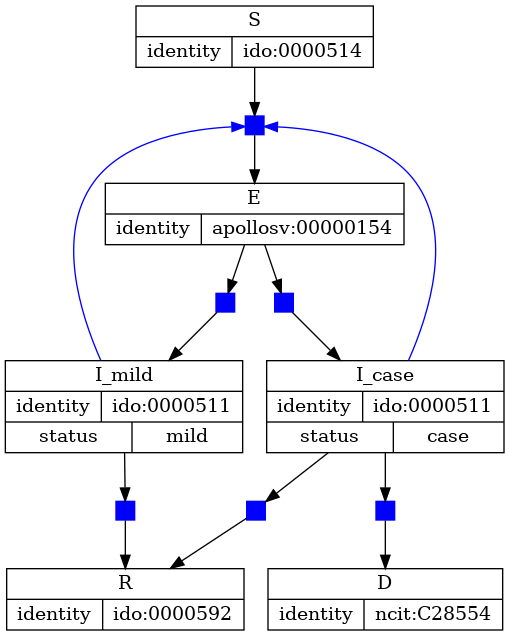

In [4]:
# Show graph of the base model
GraphicalModel.for_jupyter(seird_base)

### Stratifying by age
Each country's population is stratified by age and by the same age groups in intervals of 5 years from 0 up to 80 and then 80+.

In [5]:
age_strata = list(data['France']['population']['age_group'].values)

seird_base_age_strat = stratify(seird_base,
                                key='age',
                                strata=age_strata,
                                structure=[],
                                cartesian_control=True)
# Save model JSON
model_to_json_file(seird_base_age_strat, 'scenario1_age_strat.json')
# Don't try to create a graph, it's 4556 nodes

### Set initial values based on population by age group
The provided data contains the total population per age group

In [6]:
%%time
for country, country_data in data.items():
    pop_df = country_data['population']
    initials = {}
    for age_group, total in pop_df[['age_group', 'n']].values:
        initials.update({
            f"S_{age_group}": Initial(concept=Concept(name=f'S_{age_group}'), expression=sympy.Integer(total-1), value=total-1),
            f"E_{age_group}": Initial(concept=Concept(name=f'E_{age_group}'), expression=sympy.Integer(1), value=1),
            f"I_mild_{age_group}": Initial(concept=Concept(name=f'I_mild_{age_group}'), expression=sympy.Integer(0), value=0),
            f"I_case_{age_group}": Initial(concept=Concept(name=f'I_case_{age_group}'), expression=sympy.Integer(0), value=0),
            f"R_{age_group}": Initial(concept=Concept(name=f'R_{age_group}'), expression=sympy.Integer(0), value=0),
            f"D_{age_group}": Initial(concept=Concept(name=f'D_{age_group}'), expression=sympy.Integer(0), value=0),
        })
    # Set initials for a new copy of the age stratified model, one per country
    seird_age_strat_country = seird_base_age_strat.copy(deep=True)
    seird_age_strat_country.initials = initials

    # Save to JSON
    model_to_json_file(seird_age_strat_country, f"seird_age_strat_{country}.json")

In [7]:
# Load one model to check
# FIXME: the below errors, so something is wrong. Need to fix that.
UK_age_stratified = model_from_json_file("seird_age_strat_UK.json")

AttributeError: 'list' object has no attribute 'get'